# Movie Dataset Data inspection and preprocessing

In [845]:
import numpy as np
import pandas as pd

# Read in the data
# Because the ultimate goal of our project is to build a system which predict the revenue of non-released movies, 
# we propose that the revenue is likely to be related to the case, genere, production company, and the release date of the movie.
# In the rest of this notebook, we will try to verify our hypothesis by inspecting the data.
metadata_path = 'data/movies_metadata.csv'
credit_path = 'data/credits.csv'
ratings_path = 'data/ratings.csv'
import warnings
# warnings.filterwarnings('ignore')

metadata = pd.read_csv(metadata_path, low_memory=False)
credit = pd.read_csv(credit_path, low_memory=False)
ratings = pd.read_csv(ratings_path, low_memory=False)

In [846]:
metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


Since we are building a system that predict the revenue of un-released movies, the user ratings, votes, we will not have them.  
We will drop those columns.

In [847]:
id_to_drop = []
for i in range(45465+1):
    try:
        int_id = int(metadata['id'][i])
    except:
        print(i, metadata['id'][i], metadata['title'][i])
        id_to_drop.append(i)  

    try:
        int_id = int(metadata['budget'][i])
    except:
        print(i, metadata['budget'][i], metadata['title'][i])
        id_to_drop.append(i)  
print(set(id_to_drop))
for i in reversed(list(set(id_to_drop))):    
    metadata.drop(i, axis=0, inplace=True)

19730 1997-08-20 nan
19730 /ff9qCepilowshEtG2GYWwzt2bs4.jpg nan
29503 2012-09-29 nan
29503 /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg nan
35587 2014-01-01 nan
35587 /zaSf5OG7V8X8gqFvly88zDdRm46.jpg nan
{19730, 35587, 29503}


## Merge meta.csv with credit.csv

In [848]:
# Because the id in metadata is string, we need to convert it to int so that we can merge the two dataframes.
metadata['id'] = metadata['id'].astype(int)
metadata['budget'] = metadata['budget'].astype(int)
full_data = pd.merge(metadata, credit, left_on='id', right_on='id', how='left')

We can see that there are some nans in some of the columns, some columns has small numbers of nans which could be ignored. Some column like belongs_to_collection, nan means no collection that the movie is belong to, so we need to create special embedding for that. Another way of doing is some data might be nan in our csv but available online, we can find them and fill in it ourselves.

Here because there are hundreds of data missing in column release data and runtime, we just remove them.

## Drop datapoints that does not have a valid release data, run time

In [849]:
# Remove nans in release_date and runtime
full_data.drop(full_data[full_data['release_date'].isnull()].index, inplace=True)
full_data.drop(full_data[full_data['runtime'].isnull()].index, inplace=True)

## Only keep the month of release

In [850]:
full_data['release_date'] = pd.to_datetime(full_data['release_date'], format='%Y-%m-%d',errors='coerce').dt.month.astype(int)

## Convert json formated strings into python variables

In [851]:
import json
import math
from json.decoder import JSONDecodeError
import re
import ast

# json_columns = ['crew']
json_columns = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'cast', 'crew']
# We defined those columns as json columns because they are in json format.
def correction_and_load_json(json_str):
    if json_str == '[]':
        return []
    if isinstance(json_str, list) and len(json_str) == 0:
        return []
    if isinstance(json_str, float) and math.isnan(json_str):
        return json_str
    if isinstance(json_str, dict):
        return json_str
    if json_str is None:
        return json_str
    try:
        return json.loads(json_str)
    except JSONDecodeError as e:
        # print(e)
        # fixed_str = json_str.replace("'", '"')
        try:
            if e == 'Expecting property name enclosed in double quotes: line 1 column 2 (char 1)':
                fixed_str = '"' + json_str[:]
                fixed_str = fixed_str + '"'
            fixed_str = json_str.replace("O'", 'O')

            fixed_str = fixed_str.replace("'", '"')
            fixed_str = fixed_str.replace('None', 'null')
            return json.loads(fixed_str)
        except Exception as e:
            return ast.literal_eval(json_str)
    except TypeError:
        return json_str
    except:
        return json_str

for column in json_columns:
    full_data[column] = full_data[column].apply(correction_and_load_json)


## For some reason 83% of the movie has 0 revenue, we will have to remove those.

In [852]:
full_data

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45533,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,30840,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Robin Hood,False,5.7,26.0,"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de..."
45535,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
45536,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de..."
45537,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de..."


In [853]:

full_data = full_data[full_data['revenue'] != 0]
full_data
# full_data = full_data[full_data['crew'].apply(lambda x: not isinstance(x, str))]


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45472,False,NaN,750000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0,"[{'cast_id': 3, 'character': 'Viktor', 'credit...","[{'credit_id': '53b7a7b90e0a2676b8006ab6', 'de..."
45474,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,240789,tt1197626,ru,Чудо,The film is based on real events that took pla...,...,110.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,The Miracle,False,6.3,3.0,"[{'cast_id': 2, 'character': 'Kondrashov', 'cr...","[{'credit_id': '57f06fdfc3a3683c3e007507', 'de..."
45482,False,NaN,800000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0,"[{'cast_id': 1001, 'character': 'Mister', 'cre...","[{'credit_id': '52fe468cc3a368484e096ba7', 'de..."
45485,False,NaN,2000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0,"[{'cast_id': 1001, 'character': 'Vlad', 'credi...","[{'credit_id': '52fe46a3c3a368484e09b9fd', 'de..."


## Feature engineering: Create these discrete labels

In [854]:
has_or_not = ['belongs_to_collection', 'homepage', 'tagline']
new_column = ['has_collection', 'has_homepage', 'has_tagline']
for i in range(len(has_or_not)):
    full_data[new_column[i]] = full_data[has_or_not[i]].apply(lambda x: 0 if x is np.nan else 1)

/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/833812507.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data[new_column[i]] = full_data[has_or_not[i]].apply(lambda x: 0 if x is np.nan else 1)
/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/833812507.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data[new_column[i]] = full_data[has_or_not[i]].apply(lambda x: 0 if x is np.nan else 1)
/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/8338125

## Feature engineering: count how many crew... etc

In [855]:
# Add crew_count feature
full_data['crew_count'] = full_data['crew'].apply(lambda x: len(x) if x is not np.nan else 0)
# Add genres_count feature
full_data['genres_count'] = full_data['genres'].apply(lambda x: len(x) if x is not np.nan else 0)
# production_companies_count
full_data['production_companies_count'] = full_data['production_companies'].apply(lambda x: len(x) if x is not np.nan else 0)

/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/2307346683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['crew_count'] = full_data['crew'].apply(lambda x: len(x) if x is not np.nan else 0)
/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/2307346683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['genres_count'] = full_data['genres'].apply(lambda x: len(x) if x is not np.nan else 0)
/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124

In [856]:
full_data

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,cast,crew,has_collection,has_homepage,has_tagline,crew_count,genres_count,production_companies_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",1,1,0,106,3,1
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",0,0,1,16,3,3
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,6.1,34.0,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",0,0,1,10,3,1
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",1,0,1,7,1,2
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,7.7,1886.0,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",0,0,1,71,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45472,False,NaN,750000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,6.0,4.0,"[{'cast_id': 3, 'character': 'Viktor', 'credit...","[{'credit_id': '53b7a7b90e0a2676b8006ab6', 'de...",0,0,0,3,2,2
45474,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,240789,tt1197626,ru,Чудо,The film is based on real events that took pla...,...,6.3,3.0,"[{'cast_id': 2, 'character': 'Kondrashov', 'cr...","[{'credit_id': '57f06fdfc3a3683c3e007507', 'de...",0,0,0,4,3,3
45482,False,NaN,800000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,5.8,6.0,"[{'cast_id': 1001, 'character': 'Mister', 'cre...","[{'credit_id': '52fe468cc3a368484e096ba7', 'de...",0,0,0,2,2,0
45485,False,NaN,2000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,4.0,3.0,"[{'cast_id': 1001, 'character': 'Vlad', 'credi...","[{'credit_id': '52fe46a3c3a368484e09b9fd', 'de...",0,0,0,9,2,1


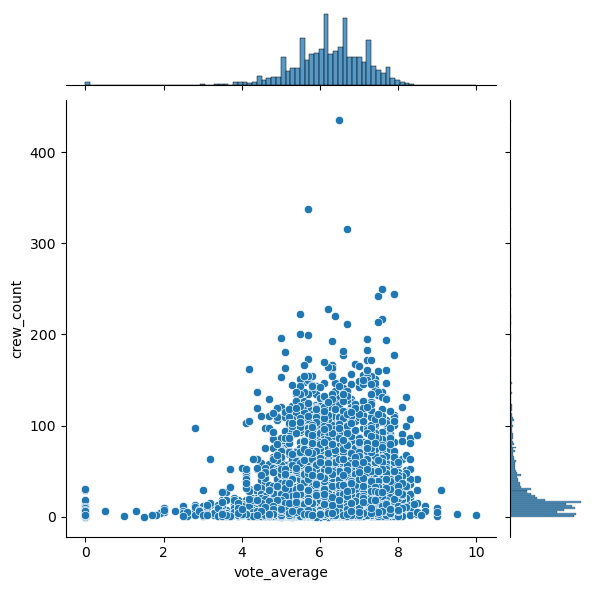

In [857]:
import seaborn as sns

# plot crew_count vs revenue
sns.jointplot(x='vote_average', y='crew_count', data=full_data)


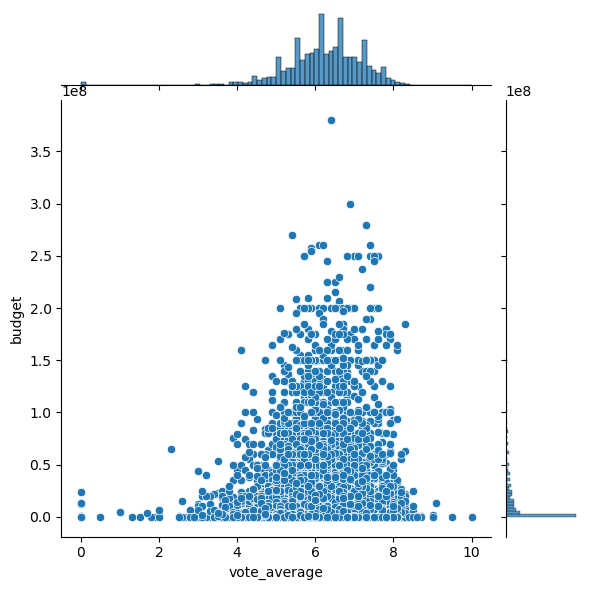

In [858]:
sns.jointplot(x='vote_average', y='budget', data=full_data)

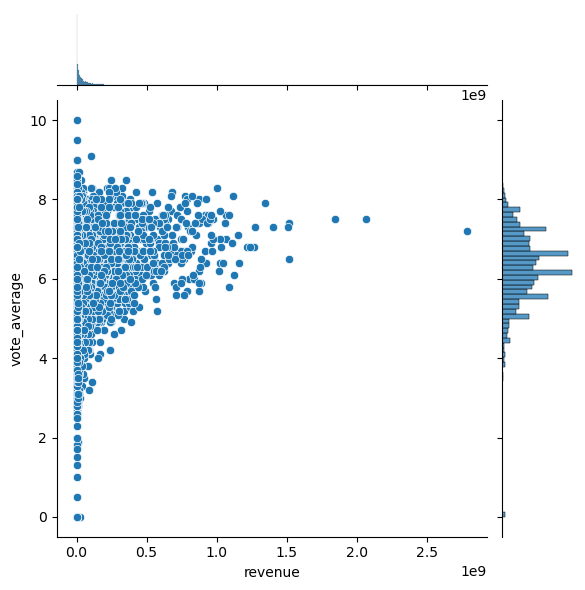

In [859]:
sns.jointplot(x='revenue', y='vote_average', data=full_data)

## Build these feature for inspection

In [860]:
full_data['genres_top'] = full_data['genres'].apply(lambda x: x[0]['name'] if x is not np.nan and len(x)>0 else np.nan)
full_data['genres_second'] = full_data['genres'].apply(lambda x: x[1]['name'] if x is not np.nan and len(x)>1 else np.nan)

/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/868758992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['genres_top'] = full_data['genres'].apply(lambda x: x[0]['name'] if x is not np.nan and len(x)>0 else np.nan)
/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/868758992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['genres_second'] = full_data['genres'].apply(lambda x: x[1]['name'] if x is not np.nan and len(x)>1 else np.nan)


## Feature engineering: Discrete features

In [861]:
full_data["has_collection"] = full_data["belongs_to_collection"].apply(lambda x: 0 if x is np.nan else 1)

/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/1880771404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data["has_collection"] = full_data["belongs_to_collection"].apply(lambda x: 0 if x is np.nan else 1)


## Create one-hot labels for movie's genres

In [862]:
unique_genre_names = list(set([genre['name'] for row in full_data['genres'] for genre in row]))
full_data['genres'] = full_data['genres'].apply(lambda x: [i['name'] for i in x])

/var/folders/1v/q7mr9jhx4fg5mfr2ts3ypb4r0000gn/T/ipykernel_42124/583438040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['genres'] = full_data['genres'].apply(lambda x: [i['name'] for i in x])


In [863]:
expanded_genres = full_data['genres'].apply(lambda x: pd.Series(x, dtype=str).value_counts()).fillna(0)
expanded_genres = expanded_genres.reindex(columns=unique_genre_names, fill_value=0)
full_data = pd.concat([full_data.drop('genres', axis=1), expanded_genres], axis=1)
full_data

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,Action,Family,Science Fiction,Adventure,Foreign,Western,Horror,History,Comedy,Drama
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,NaN,16000000,NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,False,NaN,60000000,NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45472,False,NaN,750000,NaN,280422,tt3805180,ru,Все и сразу,NaN,0.201582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45474,False,NaN,0,NaN,240789,tt1197626,ru,Чудо,The film is based on real events that took pla...,0.436028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45482,False,NaN,800000,NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",0.903061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
45485,False,NaN,2000000,NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",0.121844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Visualize

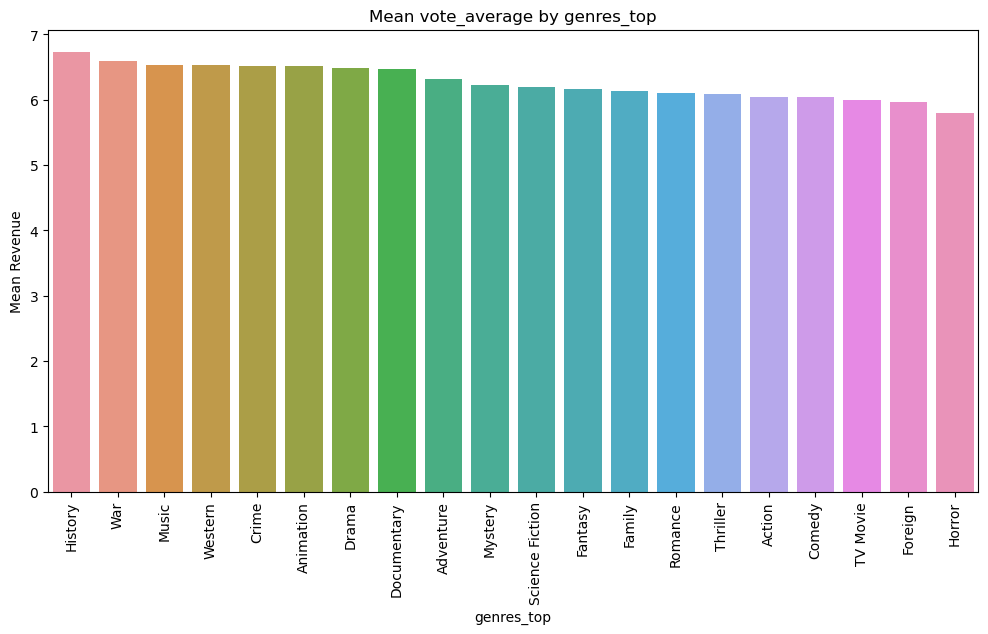

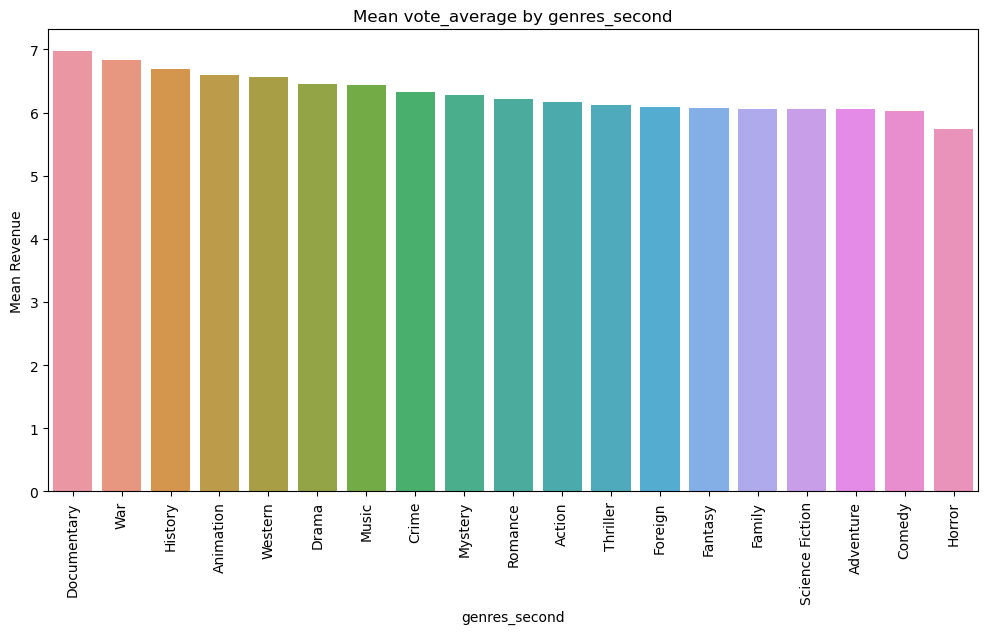

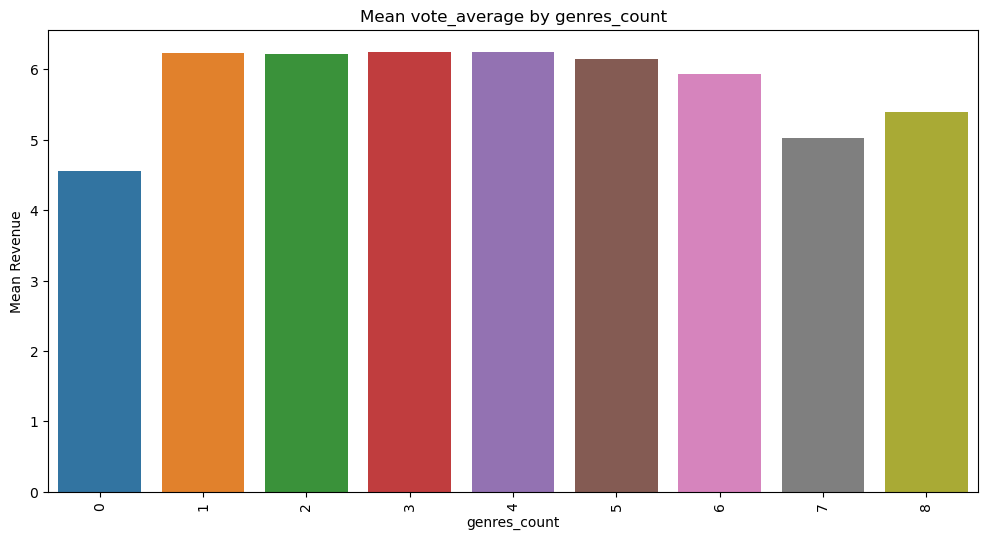

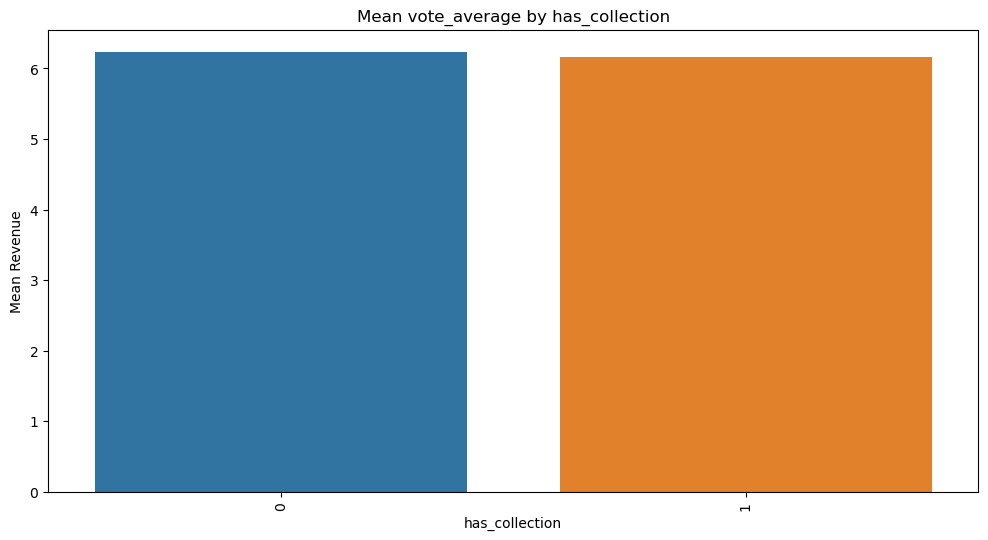

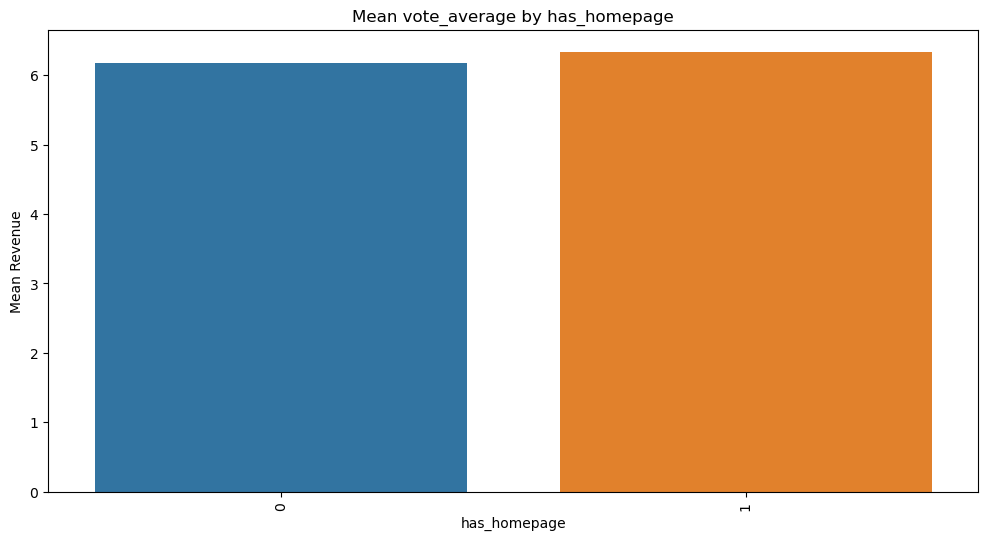

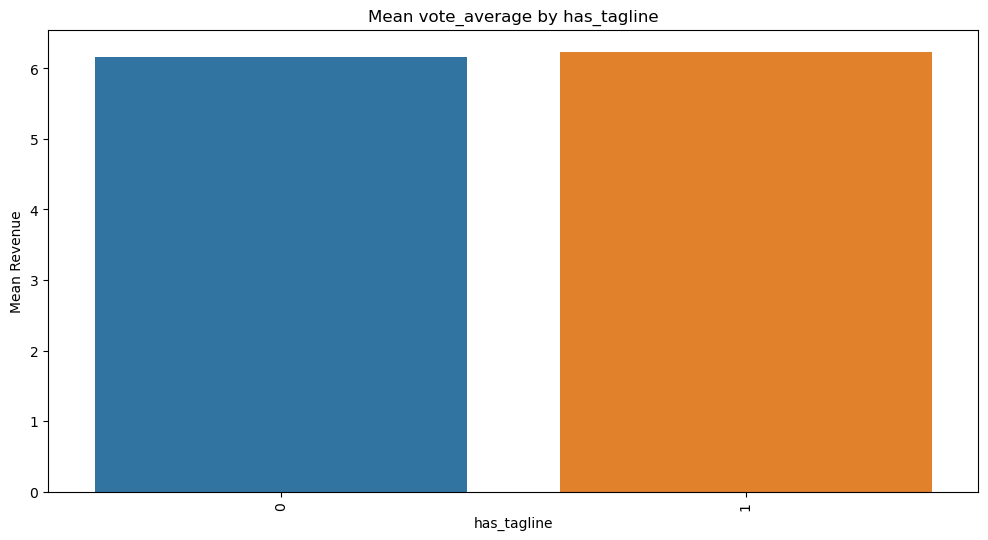

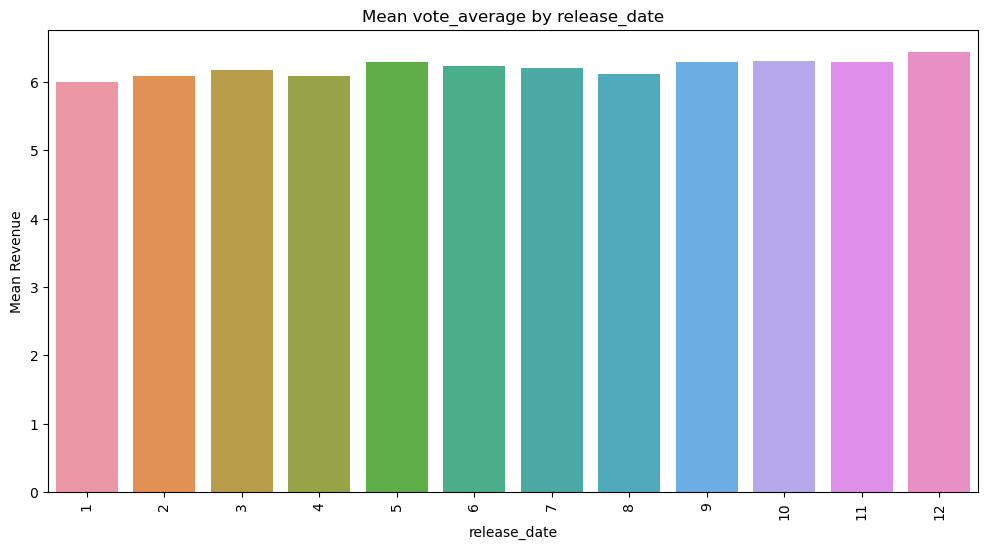

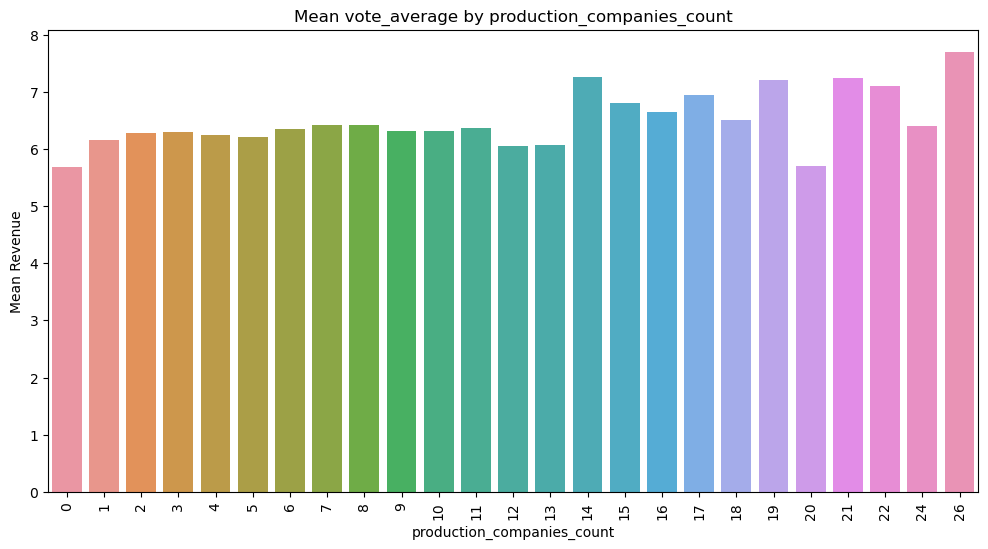

In [864]:
import matplotlib.pyplot as plt

categorical_columns = ['genres_top','genres_second', 'genres_count', 'has_collection', 'has_homepage', 'has_tagline','release_date','production_companies_count']
numerical_column = 'vote_average'


for cat_col in categorical_columns:
    mean_revenue_df = full_data.groupby(cat_col, as_index=False)[numerical_column].mean()
    mean_revenue_df = mean_revenue_df.sort_values(by=numerical_column, ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cat_col, y=numerical_column, data=mean_revenue_df)
    
    
    plt.title(f"Mean {numerical_column} by {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Mean Revenue")
    
    
    plt.xticks(rotation=90)
    plt.show()

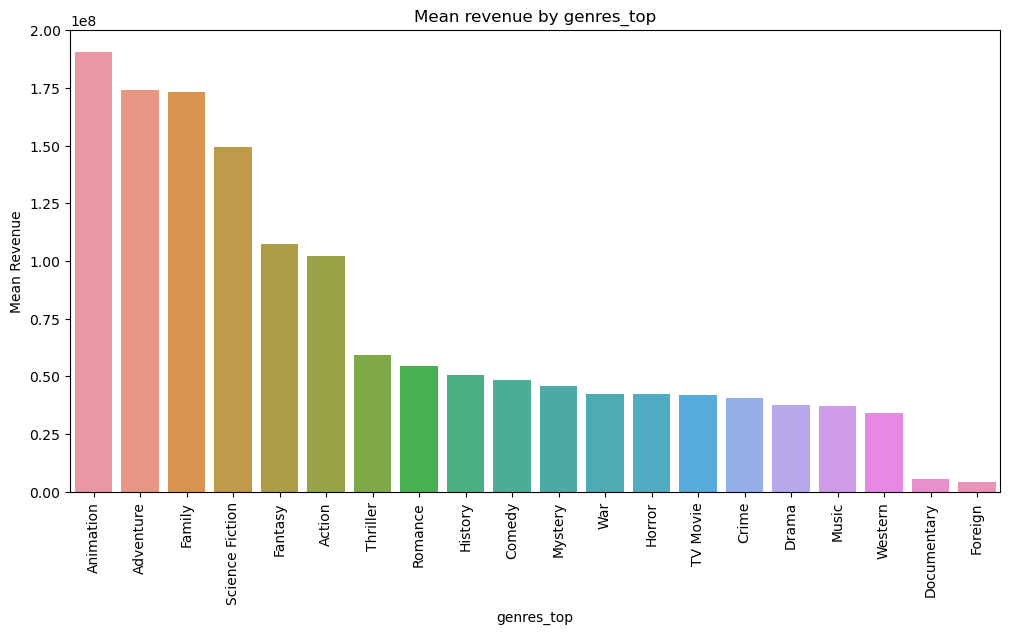

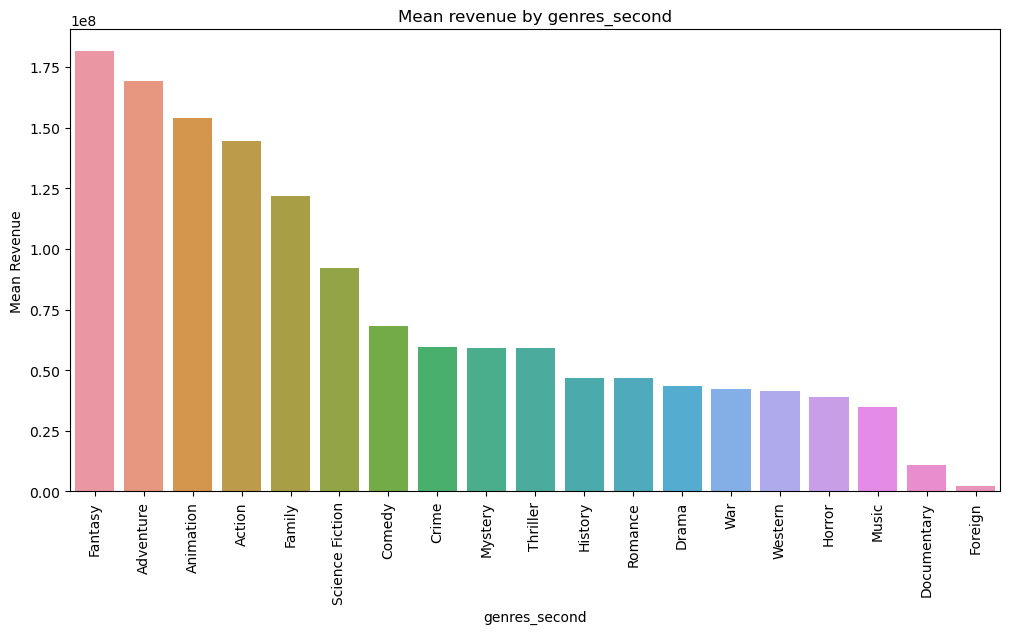

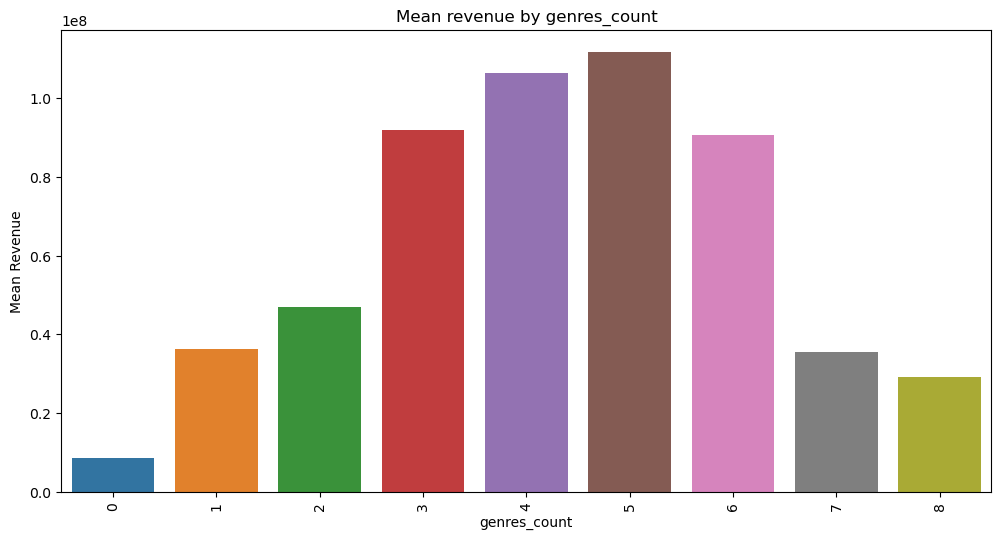

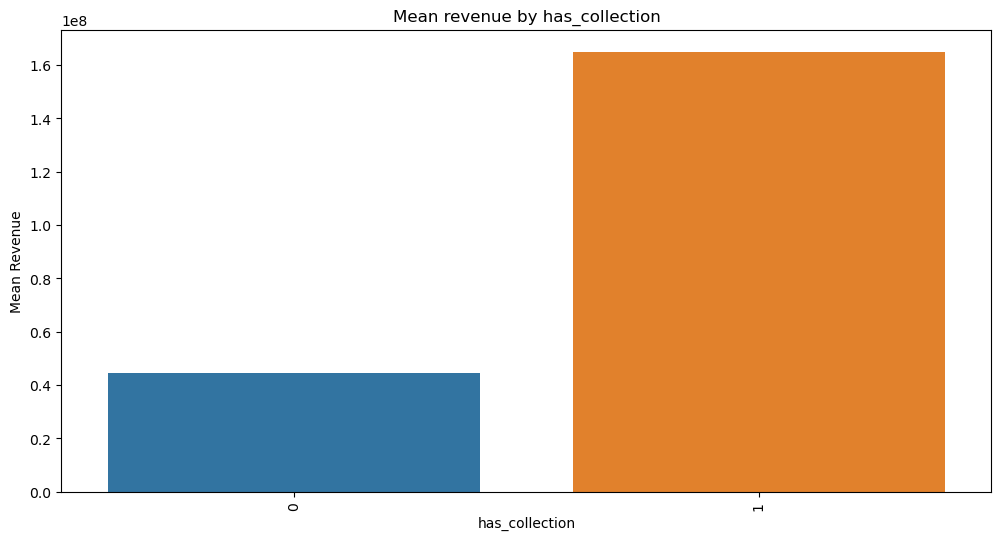

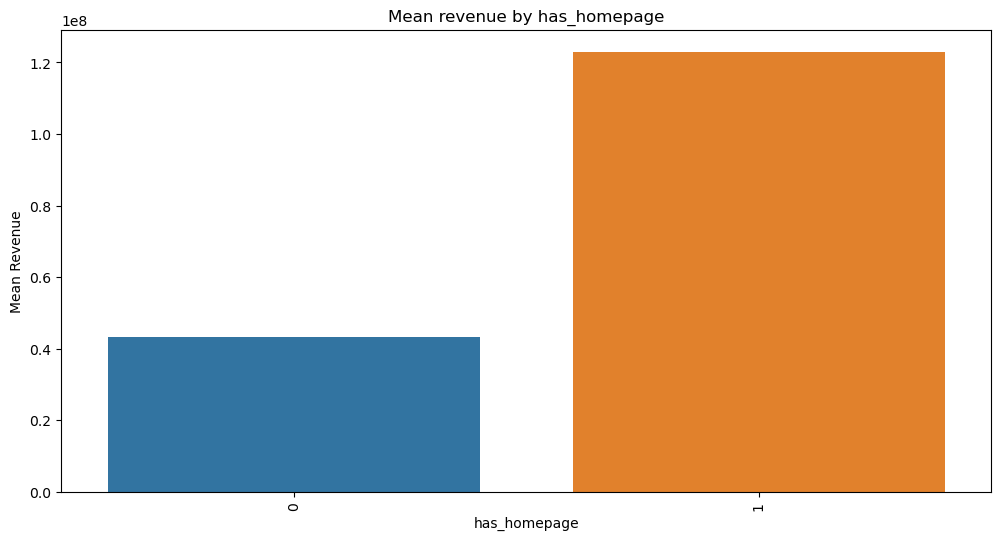

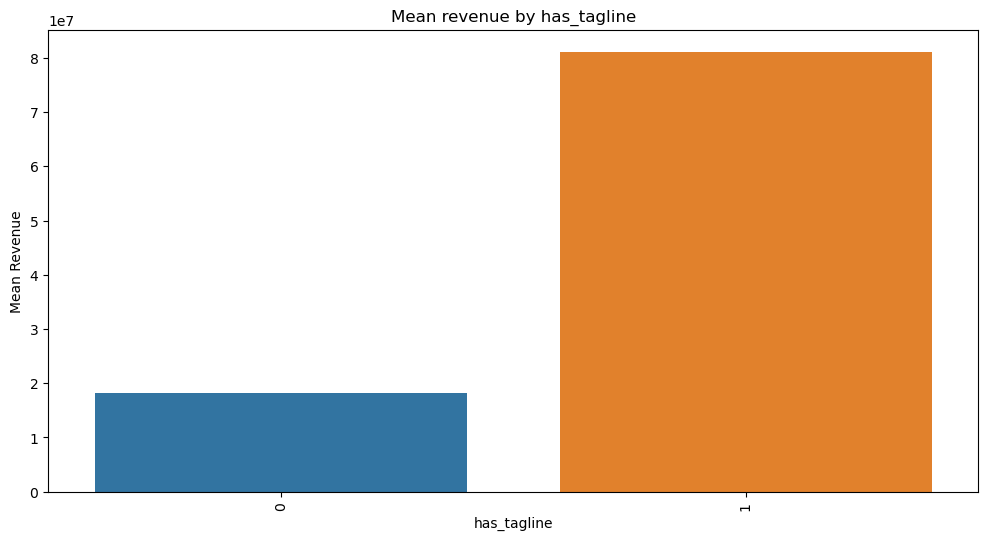

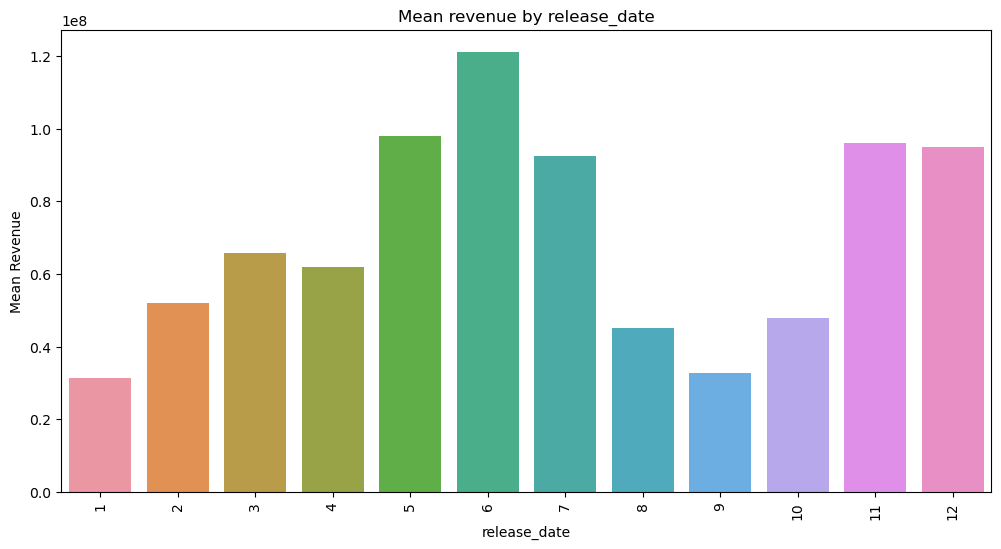

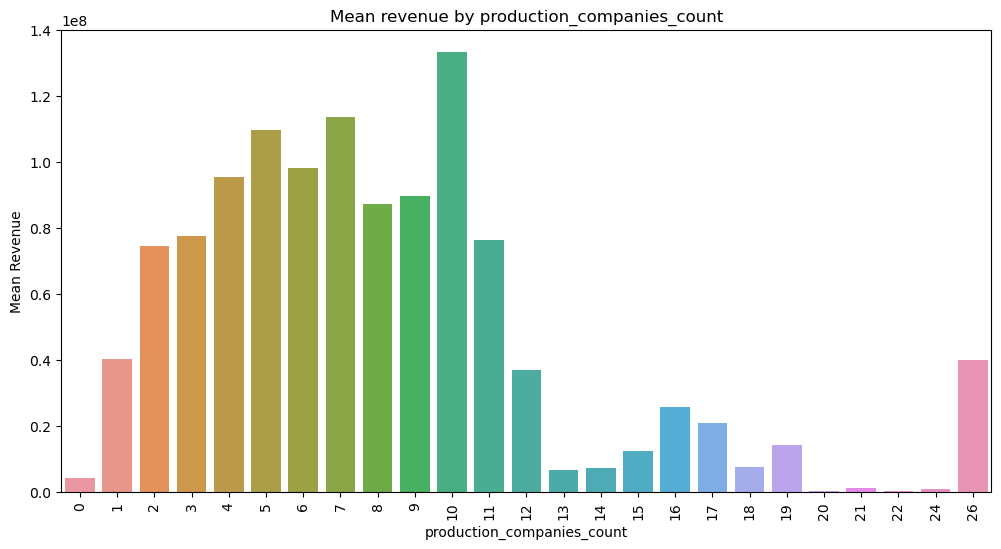

In [865]:
import matplotlib.pyplot as plt

categorical_columns = ['genres_top','genres_second', 'genres_count', 'has_collection', 'has_homepage', 'has_tagline','release_date', 'production_companies_count']
numerical_column = 'revenue'


for cat_col in categorical_columns:
    mean_revenue_df = full_data.groupby(cat_col, as_index=False)[numerical_column].mean()
    mean_revenue_df = mean_revenue_df.sort_values(by=numerical_column, ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cat_col, y=numerical_column, data=mean_revenue_df)
    
    
    plt.title(f"Mean {numerical_column} by {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Mean Revenue")
    
    
    plt.xticks(rotation=90)
    plt.show()

## Create dataset and split to train and test

In [922]:
from sklearn.model_selection import train_test_split

column_to_convert = ['genres_count', 'has_collection', 'has_homepage', 'has_tagline','release_date']
# column_to_convert = ['has_collection', 'has_homepage', 'has_tagline','release_date']
selected_data = full_data[column_to_convert]
for column_name in column_to_convert:
    color_dummies = pd.get_dummies(selected_data[column_name], prefix=column_name)
    # test_color_dummies = pd.get_dummies(selected_data[column_name], prefix=column_name)
    # Concatenate the original DataFrame with the new one-hot encoded columns
    selected_data = pd.concat([selected_data.drop(column_name, axis=1), color_dummies], axis=1)
    # selected_data = pd.concat([selected_data.drop(column_name, axis=1), test_color_dummies], axis=1)

from sklearn.preprocessing import StandardScaler

label_column = 'vote_average'

selected_data = pd.concat([selected_data, full_data[label_column]], axis=1)
selected_data = pd.concat([selected_data, full_data['budget']], axis=1)
selected_data = pd.concat([selected_data, full_data['crew_count']], axis=1)
selected_data = pd.concat([selected_data, full_data['runtime']], axis=1)
selected_data = pd.concat([selected_data, full_data['production_companies_count']], axis=1)
# selected_data = pd.concat([selected_data, full_data['genres_count']], axis=1)
selected_data = pd.concat([selected_data, full_data[unique_genre_names]], axis=1)
with pd.option_context('display.max_rows', 5,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(selected_data)

,genres_count_0,genres_count_1,genres_count_2,genres_count_3,genres_count_4,genres_count_5,genres_count_6,genres_count_7,genres_count_8,has_collection_0,has_collection_1,has_homepage_0,has_homepage_1,has_tagline_0,has_tagline_1,release_date_1,release_date_2,release_date_3,release_date_4,release_date_5,release_date_6,release_date_7,release_date_8,release_date_9,release_date_10,release_date_11,release_date_12,vote_average,budget,crew_count,runtime,production_companies_count,Crime,Music,Mystery,Romance,Animation,Documentary,TV Movie,Fantasy,Thriller,War,Action,Family,Science Fiction,Adventure,Foreign,Western,Horror,History,Comedy,Drama
0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,7.7,30000000,106,81.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,6.9,65000000,16,104.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45485,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,4.0,2000000,9,107.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45495,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,5000000,1,91.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [941]:

scaler = StandardScaler()
scaler.fit(selected_data[['crew_count']])
standardized_column = scaler.transform(selected_data[['crew_count']])
selected_data['crew_count'] = standardized_column
scaler = StandardScaler()
scaler.fit(selected_data[['runtime']])
standardized_column = scaler.transform(selected_data[['runtime']])
selected_data['runtime'] = standardized_column
scaler = StandardScaler()
scaler.fit(selected_data[['budget']])
standardized_column = scaler.transform(selected_data[['budget']])
selected_data['budget'] = standardized_column

train_data = selected_data.drop([label_column], axis=1).to_numpy().astype(np.float32)
# train_label = np.round(selected_data[label_column].to_numpy()).astype(np.float32)
train_label = selected_data[label_column].to_numpy().astype(np.float32)



In [942]:
train_data, test_data, train_label, test_label = train_test_split(train_data, train_label, test_size=0.2)
train_data.shape, train_label.shape

((5936, 51), (5936,))

## Do a regression MLP

In [943]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define a custom dataset class
class myDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

train_data_torch = torch.from_numpy(train_data)
test_data_torch = torch.from_numpy(test_data)
n_class = 2
# train_label_one_hot = np.eye(n_class)[train_label.astype(int)]
# test_label_one_hot = np.eye(n_class)[test_label.astype(int)]
train_label = train_label.reshape(-1, 1)
test_label = test_label.reshape(-1, 1)
train_label_torch = torch.from_numpy(train_label.astype(np.float32))
test_label_torch = torch.from_numpy(test_label.astype(np.float32))
train_dataset = myDataset(train_data_torch, train_label_torch)
test_dataset = myDataset(test_data_torch, test_label_torch)

N, D = train_data_torch.shape
N, D

(5936, 51)

In [944]:
trainset, valset = torch.utils.data.random_split(train_dataset, [5000, N-5000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}')

Train set size: 5000, Validation set size: 936


In [945]:
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (train_data, labels) in enumerate(trainloader): # Iterate over batches
            train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(train_data) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            # running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
            pbar.set_postfix({'loss': loss.item()})# , 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader)#, running_acc / len(trainloader) # return loss and accuracy for this epoch

In [946]:
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (train_data, labels) in enumerate(valloader): # Iterate over batches
                train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
                output = model(train_data) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item()
                #running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
                pbar.set_postfix({'loss': loss.item()})#, 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader)#, running_acc / len(valloader)  # return loss and accuracy for this epoch

In [947]:
# set the device to use and move model to device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [965]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)
    
class MLP(nn.Module):
    def __init__(self, n_feature, n_classes, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden)
        self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch


In [973]:
%%time

batchsize = 100
n_feature = D
output_class = 1
n_hidden = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

model = MLP(n_feature, output_class, n_hidden).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

n_epoch = 10
best_acc = -1
train_loss_history = []
val_loss_history = []
for epoch in range(n_epoch):
    print(f"Epoch {epoch+1}/{n_epoch}")
    train_loss = train(model, trainloader, criterion, optimizer, device)
    val_loss = validate(model, valloader, criterion, device)
    train_loss_history.append(train_loss)#; train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)#; val_acc_history.append(val_acc)
test_loss = validate(model, testloader, criterion, device)
print(f"Test loss: {test_loss:.4f}")

Epoch 1/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 467.86batch/s, loss=0.88]


Epoch 2/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 411.67batch/s, loss=0.681]


Epoch 3/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 406.92batch/s, loss=0.632]


Epoch 4/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 427.33batch/s, loss=0.628]


Epoch 5/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 388.80batch/s, loss=0.623]


Epoch 6/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 435.50batch/s, loss=0.64]


Epoch 7/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 443.54batch/s, loss=0.606]


Epoch 8/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 390.31batch/s, loss=0.636]


Epoch 9/10


Eval: 100%|██████████| 10/10 [00:00<00:00, 421.02batch/s, loss=0.604]


Epoch 10/10


Eval: 100%|██████████| 15/15 [00:00<00:00, 329.14batch/s, loss=1.12] 

Test loss: 0.8472
CPU times: user 1.69 s, sys: 495 ms, total: 2.18 s
Wall time: 2.72 s


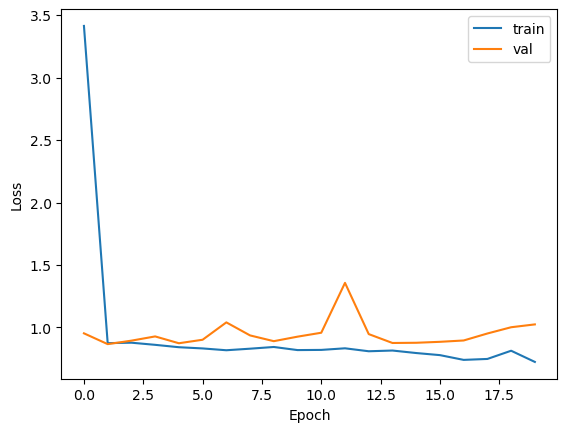

In [772]:
import matplotlib.pyplot as plt

plt.plot(np.arange(n_epoch), train_loss_history, label='train')
plt.plot(np.arange(len(val_loss_history)), val_loss_history, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [779]:
selected_data.columns

Index(['genres_count_0', 'genres_count_1', 'genres_count_2', 'genres_count_3',
       'genres_count_4', 'genres_count_5', 'genres_count_6', 'genres_count_7',
       'genres_count_8', 'has_collection_0', 'has_collection_1',
       'has_homepage_0', 'has_homepage_1', 'has_tagline_0', 'has_tagline_1',
       'release_date_1', 'release_date_2', 'release_date_3', 'release_date_4',
       'release_date_5', 'release_date_6', 'release_date_7', 'release_date_8',
       'release_date_9', 'release_date_10', 'release_date_11',
       'release_date_12', 'vote_average', 'budget', 'crew_count', 'runtime',
       'production_companies_count', 'Crime', 'Music', 'Mystery', 'Romance',
       'Animation', 'Documentary', 'TV Movie', 'Fantasy', 'Thriller', 'War',
       'Action', 'Family', 'Science Fiction', 'Adventure', 'Foreign',
       'Western', 'Horror', 'History', 'Comedy', 'Drama'],
      dtype='object')

## XGBoost

In [959]:
%%time

import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

X = train_data
y = train_label
num_folds = 5
kf = KFold(n_splits=num_folds)
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 6, 9]}
xgb_model = xgb.XGBRegressor()


grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)


best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_mse = -grid_search.best_score_
print('Best n_estimators:', best_n_estimators)
print('Best max_depth:', best_max_depth)
print('Best mean squared error:', best_mse)

Best n_estimators: 50
Best max_depth: 3
Best mean squared error: 0.7867088437080383
CPU times: user 1min 31s, sys: 50.3 s, total: 2min 21s
Wall time: 16.3 s


## KNN Regressor

In [960]:
%%time

import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

X = train_data
y = train_label
num_folds = 5
kf = KFold(n_splits=num_folds)
param_grid = {'n_neighbors': range(1, 101)}
knn = KNeighborsRegressor()


grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)


best_k = grid_search.best_params_['n_neighbors']
best_mse = -grid_search.best_score_
print('Best k:', best_k)
print('Best mean squared error:', best_mse)

Best k: 25
Best mean squared error: 0.857591164112091
CPU times: user 1min 3s, sys: 22.7 s, total: 1min 26s
Wall time: 9.26 s


## Trivial Model

In [974]:
%%time

pred_y = np.ones(train_label.shape) * np.mean(train_label)

print(f"Mean squared error: {mean_squared_error(train_label, pred_y):.4f}")

Mean squared error: 1.0330
CPU times: user 360 µs, sys: 125 µs, total: 485 µs
Wall time: 402 µs
